## Menginstall dan Import Library yang dibutuhkann

In [1]:
!pip install -q --use-deprecated=legacy-resolver tflite-model-maker
!pip install -q pycocotools

     |████████████████████████████████| 616 kB 4.1 MB/s 
     |████████████████████████████████| 213 kB 52.2 MB/s 
     |████████████████████████████████| 1.1 MB 27.9 MB/s 
     |████████████████████████████████| 840 kB 15.6 MB/s 
     |████████████████████████████████| 87 kB 5.2 MB/s 
     |████████████████████████████████| 77 kB 4.2 MB/s 
     |████████████████████████████████| 1.2 MB 37.2 MB/s 
     |████████████████████████████████| 3.4 MB 18.0 MB/s 
     |████████████████████████████████| 6.4 MB 31.7 MB/s 
     |████████████████████████████████| 596 kB 52.7 MB/s 
     |████████████████████████████████| 1.1 MB 46.7 MB/s 
     |████████████████████████████████| 120 kB 58.6 MB/s 
     |████████████████████████████████| 208 kB 46.8 MB/s 
     |████████████████████████████████| 99 kB 8.2 MB/s 
     |████████████████████████████████| 47.6 MB 2.2 MB/s 
     |████████████████████████████████| 352 kB 16.7 MB/s 
     |████████████████████████████████| 25.3 MB 1.7 MB/s 


In [2]:
import numpy as np
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.config import ExportFormat
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Mengunduh Dataset
link : https://drive.google.com/file/d/1jLX8WTaAkcteReJe_lm8Yk9BbWr7gbnT/view?usp=sharing

In [37]:
gdd.download_file_from_google_drive(file_id='1jLX8WTaAkcteReJe_lm8Yk9BbWr7gbnT',
                                    dest_path='content/Waste_Dataset_Obd.zip',
                                    unzip=True)

Unzipping...Done.


## Pra-pemrosesan Data

### Menghapus data yang tidak sesuai format (JPEG)

In [4]:
import io
import PIL.Image
import shutil

In [36]:
# shutil.rmtree("/content/content/Waste_Dataset_Obd")

In [38]:
base_dir = "/content/content/Waste_Dataset_Obd"

train_dir = base_dir + "/TRAIN"

val_dir = base_dir + "/TEST"

In [39]:
train_data = os.listdir(train_dir)
train_data.sort()

val_data = os.listdir(val_dir)
val_data.sort()

In [40]:
train_dlt_img  = []
train_dlt_ant = []
for i in range(len(train_data)):
  full_path = os.path.join('/content/content/Waste_Dataset_Obd/TRAIN/', train_data[i])
  if "jpg" not in full_path: 
    continue
  else:
    with tf.io.gfile.GFile(full_path, 'rb') as fid:
      encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = PIL.Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
      train_dlt_img.append(train_data[i])
      train_dlt_ant.append(train_data[i+1])

In [41]:
val_dlt_img  = []
val_dlt_ant = []
for i in range(len(val_data)):
  full_path = os.path.join('/content/content/Waste_Dataset_Obd/TEST/', val_data[i])
  if "jpg" not in full_path: 
    continue
  else:
    with tf.io.gfile.GFile(full_path, 'rb') as fid:
      encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = PIL.Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
      val_dlt_img.append(val_data[i])
      val_dlt_ant.append(val_data[i+1])

In [42]:
print(len(train_dlt_img))
print(len(train_dlt_ant))
print(len(val_dlt_img))
print(len(val_dlt_ant))

58
58
21
21


In [44]:
train_dlt_img[:3]

['IMG (1415).jpg', 'IMG (1424).jpg', 'IMG (1453).jpg']

In [45]:
train_dlt_ant[:3]

['IMG (1415).xml', 'IMG (1424).xml', 'IMG (1453).xml']

In [46]:
val_dlt_img[:3]

['VIMG (158).jpg', 'VIMG (221).jpg', 'VIMG (246).jpg']

In [47]:
val_dlt_ant[:3]

['VIMG (158).xml', 'VIMG (221).xml', 'VIMG (246).xml']

In [48]:
#menghapus data train yang tidak sesuai format
for i in range(len(train_dlt_img)):
  img = '/content/content/Waste_Dataset_Obd/TRAIN/' + train_dlt_img[i]
  ant = '/content/content/Waste_Dataset_Obd/TRAIN/' + train_dlt_ant[i]
  os.remove(img)
  os.remove(ant)

In [49]:
#menghapus data validasi yang tidak sesuai format
for i in range(len(val_dlt_img)):
  img = '/content/content/Waste_Dataset_Obd/TEST/' + val_dlt_img[i]
  ant = '/content/content/Waste_Dataset_Obd/TEST/' + val_dlt_ant[i]
  os.remove(img)
  os.remove(ant)

### Menghapus data yang memiliki kualitas buruk

In [50]:
from struct import unpack
from tqdm import tqdm
import os


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

In [51]:
train_data = os.listdir(train_dir)
train_data.sort()

val_data = os.listdir(val_dir)
val_data.sort()

In [52]:
bads = []

for img in tqdm(train_data):
  image = '/content/content/Waste_Dataset_Obd/TRAIN/' + img
  if "jpg" not in image: 
    continue
  else:
    # print(image)
    image = JPEG(image) 
    try:
      image.decode()   
    except:
      bads.append(img)

100%|██████████| 4248/4248 [00:01<00:00, 2900.32it/s]


In [53]:
bads

['IMG (1643).jpg', 'IMG (1920).jpg', 'IMG (822).jpg']

In [54]:
for name in bads:
  os.remove('/content/content/Waste_Dataset_Obd/TRAIN/' + name)

In [55]:
os.remove('/content/content/Waste_Dataset_Obd/TRAIN/' + 'IMG (1643).xml')
os.remove('/content/content/Waste_Dataset_Obd/TRAIN/' + 'IMG (1920).xml')
os.remove('/content/content/Waste_Dataset_Obd/TRAIN/' + 'IMG (822).xml')

In [56]:
test_bads = []

for img in tqdm(val_data):
  image = '/content/content/Waste_Dataset_Obd/TEST/' + img
  if "jpg" not in image: 
    continue
  else:
    # print(image)
    image = JPEG(image) 
    try:
      image.decode()   
    except:
      test_bads.append(img)

100%|██████████| 1058/1058 [00:00<00:00, 3965.50it/s]


In [57]:
test_bads

['VIMG (518).jpg']

In [58]:
for name in test_bads:
  os.remove('/content/content/Waste_Dataset_Obd/TEST/' + name)

In [59]:
os.remove('/content/content/Waste_Dataset_Obd/TEST/' + 'VIMG (518).xml')

## Inisialisasi dan Training Model

In [24]:
label = ['Nonrec_Glass', 'Nonrec_Other', 'Nonrec_Plastic', 'Nonrec_Tangler', 'Organik', 'Rec_Glass', 'Rec_Metal', 'Rec_Paper', 'Rec_Plastic']

In [25]:
spec = model_spec.get('efficientdet_lite2')

In [26]:
train_data = object_detector.DataLoader.from_pascal_voc(train_dir, train_dir, label)

In [27]:
validation_data = object_detector.DataLoader.from_pascal_voc(val_dir, val_dir, label)

In [28]:
model = object_detector.create(train_data, model_spec=spec, epochs=10, batch_size=10, train_whole_model=True, validation_data=validation_data)

Epoch 1/10
47/47 [==============================] - 773s 15s/step - det_loss: 1.7215 - cls_loss: 1.2077 - box_loss: 0.0103 - reg_l2_loss: 0.0772 - loss: 1.7986 - learning_rate: 0.0102 - gradient_norm: 1.8380 - val_det_loss: 1.5109 - val_cls_loss: 1.1090 - val_box_loss: 0.0080 - val_reg_l2_loss: 0.0772 - val_loss: 1.5881
Epoch 2/10
47/47 [==============================] - 759s 16s/step - det_loss: 1.2345 - cls_loss: 0.9658 - box_loss: 0.0054 - reg_l2_loss: 0.0773 - loss: 1.3118 - learning_rate: 0.0116 - gradient_norm: 3.1268 - val_det_loss: 1.2535 - val_cls_loss: 0.8923 - val_box_loss: 0.0072 - val_reg_l2_loss: 0.0773 - val_loss: 1.3309
Epoch 3/10
47/47 [==============================] - 715s 15s/step - det_loss: 0.9403 - cls_loss: 0.7418 - box_loss: 0.0040 - reg_l2_loss: 0.0774 - loss: 1.0177 - learning_rate: 0.0102 - gradient_norm: 3.1477 - val_det_loss: 0.9109 - val_cls_loss: 0.7016 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.0774 - val_loss: 0.9884
Epoch 4/10
47/47 [================

In [29]:
model.evaluate(validation_data)

2/2 [==============================] - 60s 16s/step



{'AP': 0.3161972,
 'AP50': 0.45476386,
 'AP75': 0.36347446,
 'AP_/Nonrec_Glass': 0.1476556,
 'AP_/Nonrec_Other': 0.045664813,
 'AP_/Nonrec_Plastic': 0.26600245,
 'AP_/Nonrec_Tangler': 0.4607159,
 'AP_/Organik': 0.57519627,
 'AP_/Rec_Glass': 0.22660896,
 'AP_/Rec_Metal': 0.22382747,
 'AP_/Rec_Paper': 0.3422275,
 'AP_/Rec_Plastic': 0.5578757,
 'APl': 0.32729894,
 'APm': 0.03861386,
 'APs': -1.0,
 'ARl': 0.62331706,
 'ARm': 0.0375,
 'ARmax1': 0.53394794,
 'ARmax10': 0.60772973,
 'ARmax100': 0.6095075,
 'ARs': -1.0}

In [30]:
model.export(export_dir='.')

In [31]:
model.evaluate_tflite('/content/model.tflite', validation_data)

128/128 [==============================] - 1166s 9s/step



{'AP': 0.2615316,
 'AP50': 0.36816052,
 'AP75': 0.3026129,
 'AP_/Nonrec_Glass': 8.1378e-05,
 'AP_/Nonrec_Other': 0.0,
 'AP_/Nonrec_Plastic': 0.24655735,
 'AP_/Nonrec_Tangler': 0.47631407,
 'AP_/Organik': 0.53652614,
 'AP_/Rec_Glass': 0.21290888,
 'AP_/Rec_Metal': 0.022489391,
 'AP_/Rec_Paper': 0.33148715,
 'AP_/Rec_Plastic': 0.52742,
 'APl': 0.2660939,
 'APm': 0.0,
 'APs': -1.0,
 'ARl': 0.3985289,
 'ARm': 0.0,
 'ARmax1': 0.35683525,
 'ARmax10': 0.39541104,
 'ARmax100': 0.39739797,
 'ARs': -1.0}

## Mencoba Model Object Deection

In [32]:
import platform
import json
import cv2
from PIL import Image

from typing import List, NamedTuple
from tflite_support import metadata


Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

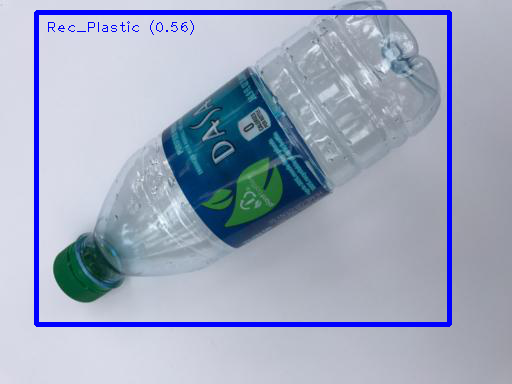

In [35]:
INPUT_IMAGE_URL = "/content/VIMG (416).jpg"
DETECTION_THRESHOLD = 0.3


im = Image.open(INPUT_IMAGE_URL)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(INPUT_IMAGE_URL, 'PNG')
image_np = np.asarray(im)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path='/content/model.tflite', options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)